# Imports

In [1]:
import gc
import math
from time import time_ns
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from numba import cuda  # must be explicitly imported
from tqdm import tqdm

if False:  # numba unhappy when used with target=cuda
    sin = np.sin
    cos = np.cos
else:
    sin = math.sin
    cos = math.cos

COMPLEXITY = 2 ** 11

# Base implementation of the test

Pure Python plus `numpy`, intentionally iterative approach.

In [2]:
def base_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

def base(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        for jdx in range(d.shape[1]):
            r[idx, jdx] = base_dummy(d[idx, jdx])
    return r

# Using `numba.vectorized`, target `cpu`

In [3]:
@nb.njit
def vectorized_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize
def vectorized(d: float) -> float:
    return vectorized_dummy(d)

# Using `numba.guvectorized`, target `cpu`

In [4]:
@nb.njit('f8(f8)')
def guvectorized_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.guvectorize('void(f8[:],f8[:])', '(n)->(n)')
def guvectorized(d: float, r: float):
    for idx in range(d.shape[0]):
        r[idx] = guvectorized_dummy(d[idx])

# Using `numba.vectorized`, target `parallel`

In [5]:
@nb.njit('f8(f8)')
def vectorized_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize('f8(f8)', target = 'parallel')
def vectorized_parallel(d: float) -> float:
    return vectorized_parallel_dummy(d)

# Using `numba.guvectorized`, target `parallel`

In [6]:
@nb.njit('f8(f8)')
def guvectorized_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.guvectorize('void(f8[:],f8[:])', '(n)->(n)', target = 'parallel')
def guvectorized_parallel(d: float, r: float):
    for idx in nb.prange(d.shape[0]):
        r[idx] = guvectorized_parallel_dummy(d[idx])

# Using `numba.vectorized`, target `cuda`

In [7]:
@cuda.jit('f8(f8)', device = True, inline = True)
def vectorized_cuda_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize('f8(f8)', target = 'cuda')
def vectorized_cuda(d: float) -> float:
    return vectorized_cuda_dummy(d)

# Using `numba.guvectorized`, target `cuda`

In [8]:
@cuda.jit('f8(f8)', device = True, inline = True)
def guvectorized_cuda_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.guvectorize('void(f8[:],f8[:])', '(n)->(n)', target = 'cuda')
def guvectorized_cuda(d: float, r: float):
    for idx in nb.prange(d.shape[0]):
        r[idx] = guvectorized_cuda_dummy(d[idx])

# Verification of results of all functions against base implementation

In [9]:
14 ** 2

196

In [10]:
funcs = [
    base,
    vectorized,
    vectorized_parallel,
    vectorized_cuda,
    guvectorized,
    guvectorized_parallel,
    guvectorized_cuda,
]

In [11]:
def test_all(rows = 14, columns = 14):
    
    data = (np.random.random(rows * columns) * 128).reshape(rows, columns).astype('f8')
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

/home/ernst/Desktop/PROJEKTE/prj.TST2/github.poliastro/env310/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# Benchmark

In [17]:
def _name(func):
    try:
        return func.__name__
    except AttributeError:  # numba#8272
        try:
            return list(func.functions.values())[0][1].py_func.__name__[13:]
        except AttributeError:  # TODO
            return list(func.kernelmap.values())[0][1].py_func.__name__[9:]

def benchmark(start = 1, stop = 10, reps = 2):
    sizes = (2 ** np.arange(start, stop + 1, 1)).astype('i8')
    results = {_name(func): [] for func in funcs[1:]}
    gc.disable()
    for size in tqdm(sizes):
        data = np.arange(0, size ** 2, 1, dtype = 'f8').reshape(size, size).copy()
        for func in funcs[1:]:  # exclude pure python
            runtimes = []
            for rep in range(reps):
                gc.collect()
                start = time_ns()
                _ = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
            results[_name(func)].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.54s/it]


# Benchmark Analysis

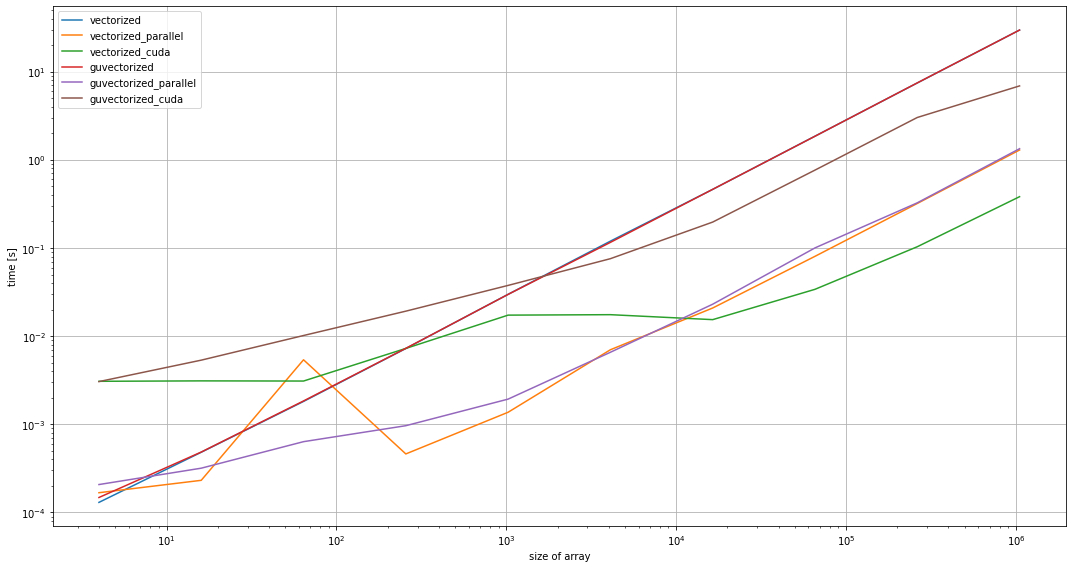

In [20]:
def plot_all(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes ** 2, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_all.jpg')

plot_all(s, r)

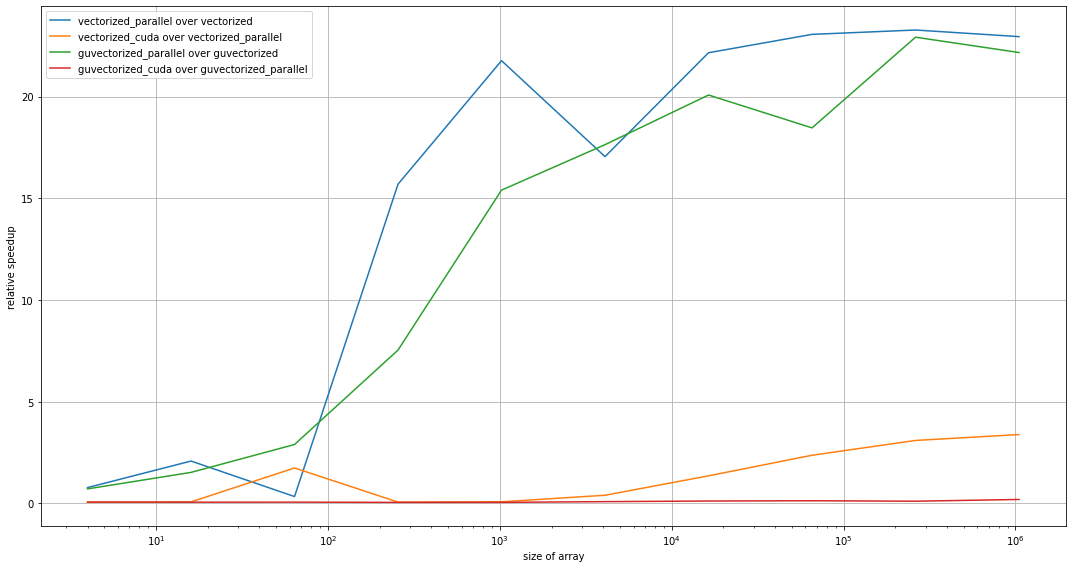

In [21]:
def plot_relative_speedup(sizes, results, pairs):
    fig, ax = plt.subplots(figsize = (15, 8))
    for base, faster in pairs:
        ax.semilogx(
            sizes ** 2,
            np.array(r[base]) / np.array(r[faster]),
            label = f'{faster:s} over {base:}',
        )
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('relative speedup')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_relative_speedup.jpg')

plot_relative_speedup(s, r, pairs = [
    ('vectorized', 'vectorized_parallel'),
    ('vectorized_parallel', 'vectorized_cuda'),
    ('guvectorized', 'guvectorized_parallel'),
    ('guvectorized_parallel', 'guvectorized_cuda'),
])

# Benchmark Raw Results

In [15]:
s

array([  2,   4,   8,  16,  32,  64, 128, 256])

In [16]:
pprint(r)

{'guvectorized': [0.000142841,
                  0.00048095200000000004,
                  0.001830208,
                  0.007271182,
                  0.028831207,
                  0.115285385,
                  0.463949233,
                  1.8548918470000002],
 'guvectorized_cuda': [0.0030576540000000004,
                       0.005332773000000001,
                       0.009905784,
                       0.019192404,
                       0.037622265,
                       0.075572231,
                       0.193164157,
                       0.754474706],
 'guvectorized_parallel': [0.00018593100000000002,
                           0.000332242,
                           0.000687023,
                           0.005469474,
                           0.001776907,
                           0.0067853,
                           0.021057202,
                           0.083678446],
 'vectorized': [0.000131301,
                0.00046808200000000004,
                0.00182081